# Characterizing climate change

This is a demo script to illustrate the power of PAIRS. While forecasting climate change is an ongoing and complex research topic, we can use PAIRS to find out how much the climate has changed in the last 4 decades.

Specifically, we will analyse daily average temperatures as reported by the [PRISM Climate Group](https://prism.oregonstate.edu/) for the Conterminous United States. At first, we will do a fairly conventional analysis, aggregateing the daily temperature anomaly across the entire area. This will give us a statistically robust idea of the total degree of warming.

Exploiting PAIRS however, we can drill deeper. Specifically, we will do the same analysis at each pixel. Doing so we will find that different parts of the country are affected to different degrees.

In [64]:
from ibmpairs import paw, authentication
import matplotlib.pyplot as plt, pandas as pd, numpy as np, os
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import logging

We set some auxiliary variables and configure the logging system. E.g. `iso8601` helps when converting datetime objects to strings in ISO 8601-compliant format.

In [2]:
one_sec = timedelta(seconds=1)
iso_8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
paw_logger = logging.getLogger('ibmpairs.paw')
paw_logger.setLevel(logging.ERROR)

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [3]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

Specifically, we use `authentication.OAuth2` to retrieve the access token:

In [4]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.


## Data availability

The PRISM data is in the dataset **Daily US weather (PRISM)**, which has ID 9. The layers we are interested in are the daily average temperature (layer ID 94) and the corresponding historical climate (layer ID 49004).

It is always a good idea to start with a point query. So we will do that. Specifically we want to get an idea of the temporal coverage of the data.

In [72]:
query_json_point = {
    'layers' : [
        {'id' : '94'},
        {'id' : '49004'}
    ],
    'spatial' : {'type' : 'point', 'coordinates' : [45, -100]},
    'temporal' : {'intervals' : [{'start' : '1900-01-01', 'end' : '2030-01-01'}]}
}

In [73]:
query_point = paw.PAIRSQuery(query_json_point, auth=pairs_credentials, authType='api-key')
query_point.submit()

In [74]:
df_point = query_point.vdf.pivot(index='timestamp', columns='layerId', values='value')
df_point

layerId,94,49004
timestamp,,
1980-12-31 12:00:00+00:00,272.238403,NaN
1981-01-01 12:00:00+00:00,269.388214,NaN
1981-01-02 12:00:00+00:00,265.669159,NaN
1981-01-03 12:00:00+00:00,258.743317,NaN
1981-01-04 12:00:00+00:00,264.223785,NaN
...,...,...
2021-09-05 12:00:00+00:00,292.536591,NaN
2021-09-06 12:00:00+00:00,295.376038,NaN
2021-09-07 12:00:00+00:00,291.236664,NaN


The data ranges from 1981 to now. Since we want to analyze entire years, we restrict our analysis to the 40 year period from 1981 to 2020.

Note that the climatology (49004) only covers a single year. Strictly speaking, a climatology is independent of the year. Convention for PAIRS is to store such data to a year that is "significant for the data set in question"; usually that is the end of the period from which data was used to calculate the climate normal or the year the product was generated.

In [75]:
prism_years = range(1981, 2021)

## US-wide analysis

As mentioned before, we start with an aggregate analysis. Spatial aggregation is done via the line
```
'spatial' : {'type' : 'poly', 'aoi' : '24', 'aggregation' : {'aoi' : ['24']}}
```
This queries the data for the CONUS polygon (ID 24) and then aggregates it over the same area. One could change the above to query CONUS (same ID) but then aggregate over each state or even country.

In order for the spatial aggregation to be meaningful, it is better to compare temperature anomalies than totals. Thus, we need to calculate the difference of observed value and historical normal. We do so using user defined functions. Studying the following query, note the use of `'output' : False` for data we only need for this computation but do not want to download. The actual anomalies are calculated via the _User defined function_ (UDF)
```
'expression' : f'$annual_mean_temp_{y} - $annual_mean_temp_normal'
```

See [the tutorials](https://pairs.res.ibm.com/tutorial/tutorials/api/udfs.html) for details on UDFs.

In [9]:
query_json_spatial_aggregate = {
    'layers' : [
        {
            'alias' : 'annual_mean_temp_normal',
            'id' : '49004',
            'aggregation' : 'Mean',
            'temporal' : {
                'intervals' : [
                    {'start' : '2015-12-31', 'end' : '2016-12-31'}
                ]
            },
            'output' : False
        }
    ],
    'spatial' : {'type' : 'poly', 'aoi' : '24', 'aggregation' : {'aoi' : ['24']}},
    'temporal' : {
        'intervals' : [
            {'snapshot' : datetime(2020, 1, 1).strftime(iso_8601)}
        ]
    }
}

for y in prism_years:
    query_json_spatial_aggregate['layers'].extend(
        [
            {
                'alias' : f'annual_mean_temp_{y}',
                'id' : '94',
                'aggregation' : 'Mean',
                'temporal' : {
                    'intervals' : [
                        {'start' : datetime(y, 1, 1).strftime(iso_8601), 'end' : datetime(y+1, 1, 1).strftime(iso_8601)}
                    ]
                },
                'output' : False
            },
            {
                'alias' : f'annual_mean_temp_anomaly_{y}',
                'expression' : f'$annual_mean_temp_{y} - $annual_mean_temp_normal'
            }
        ]
    )

We submit the query, telling the `paw` library to use local data instead of querying PAIRS if we have run the query before (`overwriteExisting=False`).

In [11]:
query_spatial_aggregate = paw.PAIRSQuery(
    query_json_spatial_aggregate, auth=pairs_credentials, authType='api-key', overwriteExisting=False
)
query_spatial_aggregate.submit()

The query might take ten minutes to run. You can check the status via the following:

In [57]:
query_spatial_aggregate.poll()
query_spatial_aggregate.queryStatus.json()['status']

'Succeeded'

Alternatively, you can simply call `poll_till_finished()`, which checks query status in regular intervals but effectively locks this notebook.

In either case, once the query is completed you can download the data (`download()`) and load it to memory (`create_layers()`). This was not necessary for the nore lightweight point query we defined above.

In [58]:
query_spatial_aggregate.poll_till_finished()
query_spatial_aggregate.download()
query_spatial_aggregate.create_layers()

Finally, we load the data to a pandas data frame.

In [62]:
df_spatial_aggregate = pd.DataFrame.from_dict(
    {k : v.iloc[0] for k, v in query_spatial_aggregate.data.items()},
    orient='index'
)
df_spatial_aggregate['Year'] = df_spatial_aggregate.index.str.extract('([0-9]{4})', expand=False).astype(int)
df_spatial_aggregate = df_spatial_aggregate.set_index('Year').sort_index()
df_spatial_aggregate.head()

,PAIRS polygon ID,count()[unit: km^2],min(),max(),mean(),2nd moment
Year,,,,,,
1981,24.0,7.873282e+06,-1.79260,1.77472,0.106028,0.436190
1982,24.0,7.873282e+06,-3.56687,1.21395,-0.816436,1.042462
1983,24.0,7.873282e+06,-3.03298,1.31379,-0.545716,0.511402
1984,24.0,7.873282e+06,-2.90594,1.28955,-0.497876,0.564844
1985,24.0,7.873282e+06,-3.47916,0.80276,-0.815764,1.061790


### Adding a linear fit

We use scikit-learn to calculate a regression line.

In [65]:
model = LinearRegression()
model.fit(
    df_spatial_aggregate.index.values.reshape((-1, 1)),
    df_spatial_aggregate['mean()'].values
)
print(f'{model.coef_[0]}')

0.02326603526020888


We see that we have warming of about 0.23°C/year for the CONUS area.

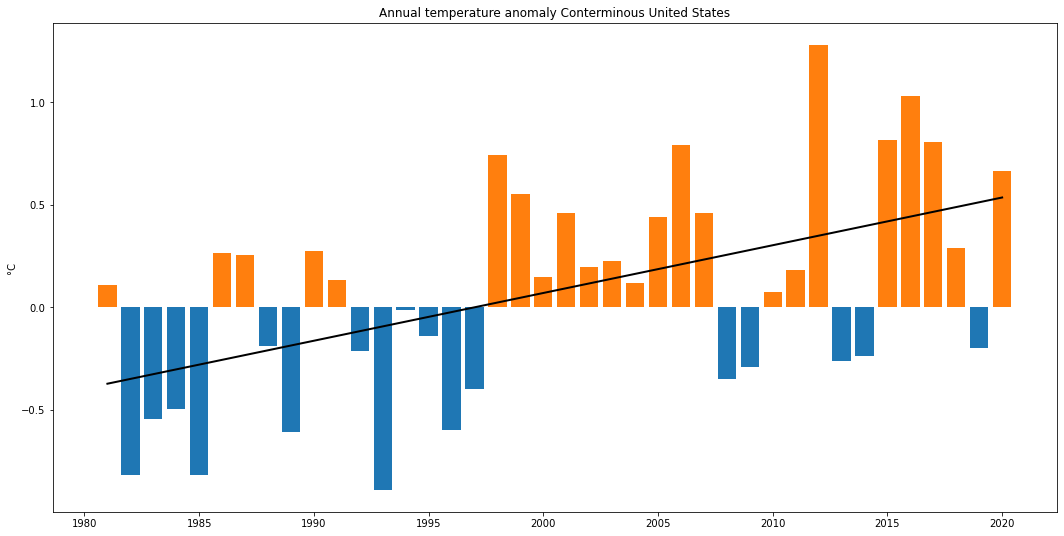

In [71]:
exceeds = df_spatial_aggregate['mean()'] >= 0

_, ax = plt.subplots(1, 1, figsize=(18, 9))
ax.bar(df_spatial_aggregate[exceeds].index, df_spatial_aggregate.loc[exceeds, 'mean()'], color='C1')
ax.bar(df_spatial_aggregate[~exceeds].index, df_spatial_aggregate.loc[~exceeds, 'mean()'], color='C0')
ax.plot(
    df_spatial_aggregate.index, model.predict(df_spatial_aggregate.index.values.reshape((-1, 1))), color='black', linewidth=2
)
ax.set_title('Annual temperature anomaly Conterminous United States')
ax.set_ylabel('°C')
plt.savefig('TemperatureAnomalyCONUS.png', dpi=60, bbox_inches='tight', transparent=True)

## Local analysis

We will repeat the same analysis locally. Since we are not performing the spatial aggregate and are working with annual means, there is no need to calculate the anomaly. This will simplify our query description.

Even though we will only call it once, we write a function that generates the required query JSON. This query relies heavily on UDFs. The result is that the entire analysis runs in maybe another ten minutes in the PAIRS cluster.

In [16]:
def build_query(parameter, layer_id, aggregation, aoi, years):
    query_json = {
        'layers' : [],
        'spatial' : {'type' : 'poly', 'aoi' : aoi},
        'temporal' : {
            'intervals' : [
                {'snapshot' : datetime(2020, 1, 1).strftime(iso_8601)}
            ]
        }
    }

    for y in years:
        query_json['layers'].extend(
            [
                {
                    'alias' : f'year_{y}',
                    'id' : str(layer_id),
                    'aggregation' : aggregation,
                    'temporal' : {
                        'intervals' : [
                            {'start' : datetime(y, 1, 1).strftime(iso_8601), 'end' : datetime(y+1, 1, 1).strftime(iso_8601)}
                        ]
                    },
                    'output' : False
                }
            ]
        )

    query_json['layers'].extend(
        [
            {
                'alias' : 'mu_x',
                'expression' : '(' + '+'.join([f'{y}' for y in years]) + f') / {len(years)}',
                'output' : False
            },
            {
                'alias' : 'mu_y',
                'expression' : '(' + '+'.join([f'$year_{y}' for y in years]) + f') / {len(years)}',
                'output' : False
            },
            {
                'alias' : 'sigma_xx',
                'expression' : '+'.join(
                    [
                        f'({y} - $mu_x)*({y} - $mu_x)' for y in years
                    ]
                ),
                'output' : False
            },
            {
                'alias' : 'sigma_yy',
                'expression' : '+'.join(
                    [
                        f'($year_{y} - $mu_y)*($year_{y} - $mu_y)' for y in years
                    ]
                ),
                'output' : False
            },
            {
                'alias' : 'sigma_xy',
                'expression' : '+'.join(
                    [
                        f'({y} - $mu_x)*($year_{y} - $mu_y)' for y in years
                    ]
                ),
                'output' : False
            },
            {
                'alias' : f'{parameter} change',
                'expression' : '$sigma_xy / $sigma_xx'
            },
            {
                'alias' : f'{parameter} change error',
                'expression' : f'math:sqrt(($sigma_yy - ($sigma_xy*$sigma_xy / $sigma_xx)) / ($sigma_xx + {len(years) - 2}))'
            }
        ]
    )
    
    return query_json

Subsequently we build the query JSON, submit the query and wait for it to complete.

In [17]:
query_json_map = build_query('Temperature', 94, 'Mean', '24', prism_years)

In [19]:
query_map = paw.PAIRSQuery(
    query_json_map, auth=pairs_credentials, authType='api-key', overwriteExisting=False
)
query_map.submit()

In [25]:
query_map.poll()
query_map.queryStatus.json()['status']

'Succeeded'

In [26]:
query_map.poll_till_finished()
query_map.download()
query_map.create_layers()

We can plot our results.

In [46]:
slope = query_map.data['Expression-Temperature change[Temperature change]-Exp']
error = query_map.data['Expression-Temperature change error[Temperature change error]-Exp']
b_box = query_map.metadata['Expression-Temperature change[Temperature change]-Exp']['details']['boundingBox']
extent = (b_box['minLongitude'], b_box['maxLongitude'], b_box['minLatitude'], b_box['maxLatitude'])
amax_slope = np.nanmax(np.abs(slope))

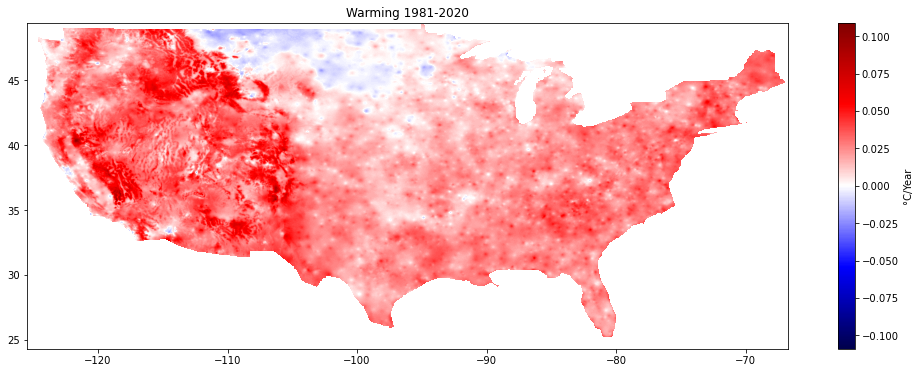

In [51]:
_, ax = plt.subplots(1, 1, figsize=(18, 6))
img = ax.imshow(
    slope, vmin=-amax_slope, vmax=amax_slope,
    cmap='seismic', extent=extent
)
ax.set_title(f'Warming {min(prism_years)}-{max(prism_years)}')
plt.colorbar(img, ax=ax, label='°C/Year')
plt.savefig('Regional_warming_CONUS.png', dpi=60, bbox_inches='tight')

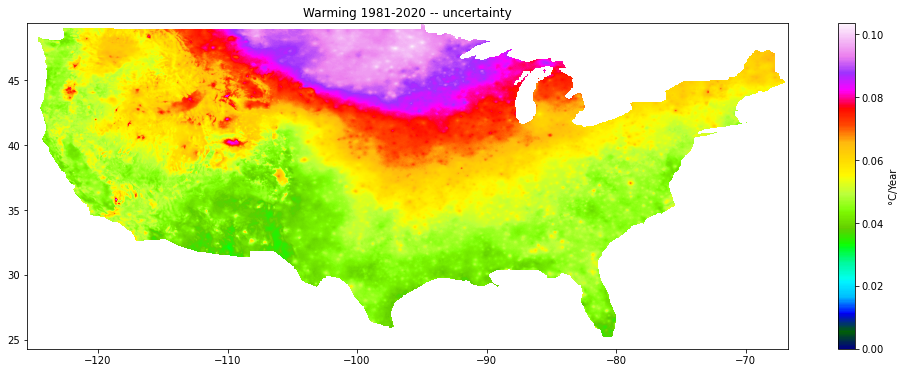

In [56]:
_, ax = plt.subplots(1, 1, figsize=(18, 6))
img = ax.imshow(
    error, vmin=0,
    cmap='gist_ncar', extent=extent
)
ax.set_title(f'Warming {min(prism_years)}-{max(prism_years)} -- uncertainty')
plt.colorbar(img, ax=ax, label='°C/Year')
plt.savefig('Regional_warming_CONUS_uncertainty.png', dpi=60, bbox_inches='tight')

One might be concerned by the size of the errors. However, while the data at each point is somewhat noisy, the spatial correlations inherent in temperature data indicate that the point-wise analysis of errors we did above is not entirely appropriate.

In other words, had we done the analysis only at a single point, one might want to take the resulting slope at that point with a large grain of salt. The fact that we obtain similar slopes across the map tells us that we can trust the regional effects we reproduced earlier. I.e. we do find that the West is more heavily affected by warming than the East and that the central North is least affected.